In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from torch import nn
from tqdm import tqdm
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device, torch.cuda.get_device_name(0))

cuda NVIDIA GeForce RTX 3080


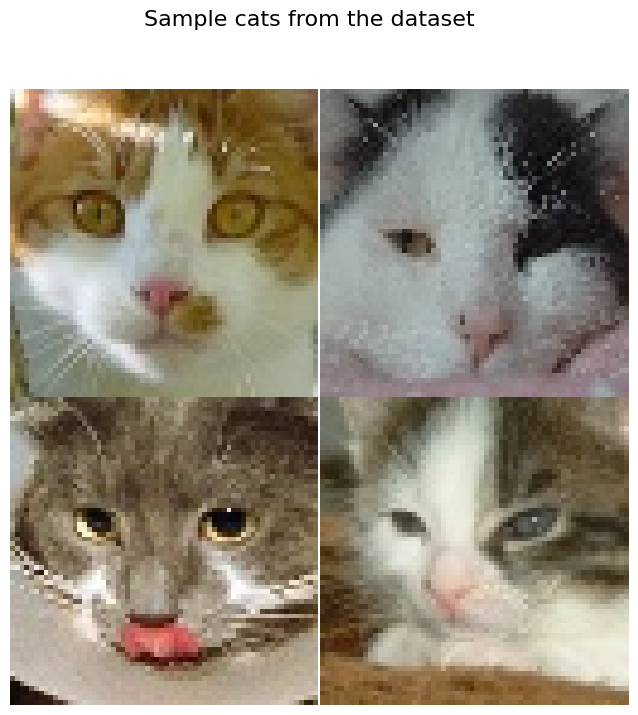

In [2]:
data_dir = '../data/cats_GAN'
batch_size = 5
im_size = 64

def load_transformed_dataset(test_split):
    transform = transforms.Compose([
            transforms.Resize((im_size, im_size)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1)
            ])

    dataset = datasets.ImageFolder(data_dir, transform=transform)

    test_size = int(test_split * len(dataset))
    train_size = len(dataset) - test_size

    train, test = random_split(dataset, [train_size, test_size])
    return torch.utils.data.ConcatDataset([train, test])

def denorm(image):
    return (image + 1) / 2

def show_sample_images(images):
    n_samples = min(images.size(0), 64)
    n_row = int(np.sqrt(batch_size))
    n_col = n_samples // n_row

    images = denorm(images[:n_samples])
    _, axes = plt.subplots(n_row, n_col, figsize=(8, 8))

    plt.suptitle("Sample cats from the dataset", fontsize=16)

    for i, ax in enumerate(axes.flat):
        image = images[i]
        ax.imshow(image.permute(1, 2, 0))
        ax.axis('off')
    
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

def show_tensor_image(image, title=None):
    if len(image.shape) == 4:
        image = image[0, :, :, :] 

    image = denorm(image)
    image = image.permute(1, 2, 0)
    image = image.clip(0, 1)

    if title:
        plt.suptitle(title, fontsize=16)

    plt.imshow(image.cpu())

def show_tensor_images(images, title=None):
    columns = images.shape[0]
    fig = plt.figure(figsize=(15, 3)) 
    
    if title:
        plt.suptitle(title, fontsize=16)

    for i in range(columns):
        fig.add_subplot(1, columns, i+1)
        image = images[i]
        image = denorm(image)
        image = image.permute(1, 2, 0)
        image = image.clip(0, 1)
        plt.imshow(image.cpu())
        plt.axis('off') 

data = load_transformed_dataset(test_split=0.2)
dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)

for batch in dataloader:
    images, _ = batch
    show_sample_images(images)
    break

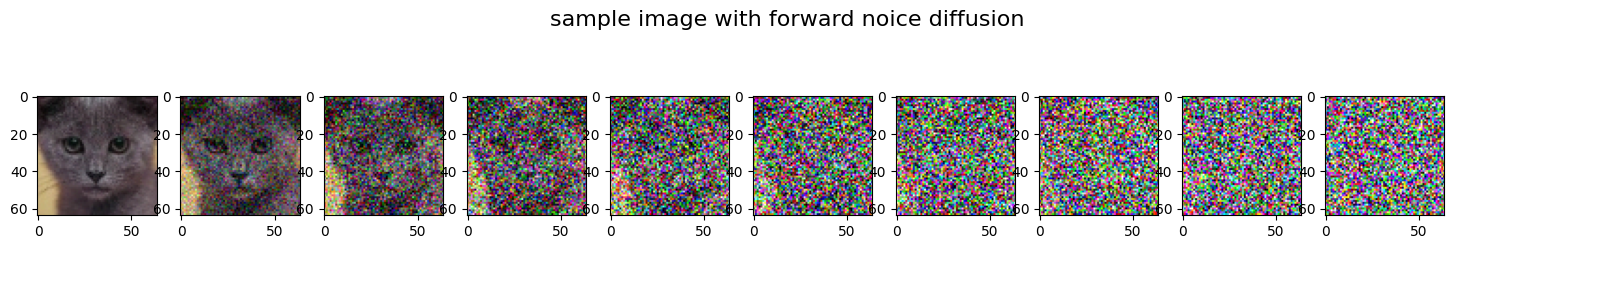

In [3]:
class Diffusion:
    def __init__(self, T=500, Beta_1=0.0001, Beta_T=0.02, im_size=im_size):
        self.T = T
        self.Beta_1 = Beta_1
        self.Beta_T = Beta_T
        self.im_size = im_size
        self.betas = self.noice_schedule() 
        self.alphas = 1 - self.betas                                             # αt:= 1 − βt
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)                 # α¯t:= Πt s=1 αs
                
    def noice_schedule(self):
        return torch.linspace(self.Beta_1, self.Beta_T, self.T).to(device)

    def forward_diffusion(self, x_0, t):
        # x_0 is the original image without noise
        # t is the iteration number of adding noise
        noise = torch.randn_like(x_0)
        sqrt_alphas_ = torch.sqrt(self.alphas_cumprod[t])[:, None, None, None]
        one_minus_sqrt_alphas_ = torch.sqrt(1 - self.alphas_cumprod[t])[:, None, None, None]

        return sqrt_alphas_.to(device) * x_0.to(device) + one_minus_sqrt_alphas_.to(device) * noise.to(device), noise.to(device)

    def random_timestamps(self, n):
        return torch.randint(low=1, high=self.T, size=(n, ))

    def sample(self, model, n):
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, 3, im_size, im_size)).to(device)            # create random noise iamge
            for t in tqdm(range(self.T - 1, 0, -1), position=0):     
                time_stamps = (torch.ones(n) * t).long().to(device)        # create time stamps
                predicted_noise = model(x, time_stamps)
                alpha = self.alphas[time_stamps][:, None, None, None]
                alpha_overhead = self.alphas_cumprod[time_stamps][:, None, None, None]
                beta = self.betas[time_stamps][:, None, None, None]
                if t > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_overhead))) * predicted_noise) + torch.sqrt(beta) * noise
        model.train()
        x = x.clamp(-1, 1)
        return x

# x_0 is the original image
# x_t is the original image after adding noise "t" times
# q(x_t | x_t-1) -> return image after "t" noise iteration (x_t) on the given previously image (x_t-1)       zwykła funkcja
# p(x_t-1 | x_t) -> reverse process, gets image with "t" iterations of noise and tries to remove noise       model


diffiusion = Diffusion(T=500)

num_images = 10
stepsize = int(diffiusion.T/num_images)
image = next(iter(dataloader))[0]

plt.figure(figsize=(20,3))
plt.axis('off')
for idx in range(0, diffiusion.T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = diffiusion.forward_diffusion(image, t)
    show_tensor_image(img, title="sample image with forward noice diffusion")

In [4]:
class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class UNet(nn.Module):
    def __init__(self, c_in=3, c_out=3, time_dim=256, device="cuda"):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128, 32)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256, 16)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256, 8)

        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)

        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128, 16)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64, 32)
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention(64, 64)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)

        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)
        return output

In [5]:
lr = 3e-4
epochs = 100
model = UNet().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
mse = nn.MSELoss()
diffusion = Diffusion(T=500)

l = len(dataloader)

In [6]:
for epoch in range(epochs):
    pbar = tqdm(dataloader)
    for i, (images, _) in enumerate(pbar):
        images = images.to(device)
        t = diffusion.random_timestamps(images.shape[0]).to(device)
        x_t, noise = diffusion.forward_diffusion(images, t)
        predicted_noise = model(x_t, t)
        loss = mse(noise, predicted_noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_postfix(MSE=loss.item())

    if epoch % 5 == 0:
        sampled_images = diffusion.sample(model, n=images.shape[0])
        show_tensor_images(sampled_images, title=f"Sample images after {epoch} epochs")


  2%|▏         | 56/3150 [00:10<10:03,  5.13it/s, MSE=0.208]


KeyboardInterrupt: 